# Age Distribution by Therapy Area in MIMIC3 Demo Dataset

This notebook analyzes the age distribution across different therapy areas using the MIMIC3 demo dataset.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyhealth.datasets import MIMIC3Dataset
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [16]:
# Load MIMIC3 demo dataset
print("Loading MIMIC3 demo dataset...")
mimic3_demo = MIMIC3Dataset(
    root="https://physionet.org/files/mimiciii-demo/1.4/",
    tables=["DIAGNOSES_ICD", "PATIENTS", "ADMISSIONS"],
    dev=True  # Use dev mode for small subset
)

print(f"Dataset statistics:")
mimic3_demo.stats()

Loading MIMIC3 demo dataset...
No config path provided, using default config
Initializing mimic3 dataset from https://physionet.org/files/mimiciii-demo/1.4/ (dev mode: True)
Scanning table: patients from https://physionet.org/files/mimiciii-demo/1.4/PATIENTS.csv.gz
Original path does not exist. Using alternative: https://physionet.org/files/mimiciii-demo/1.4/PATIENTS.csv
Scanning table: admissions from https://physionet.org/files/mimiciii-demo/1.4/ADMISSIONS.csv.gz


Original path does not exist. Using alternative: https://physionet.org/files/mimiciii-demo/1.4/ADMISSIONS.csv
Scanning table: icustays from https://physionet.org/files/mimiciii-demo/1.4/ICUSTAYS.csv.gz
Original path does not exist. Using alternative: https://physionet.org/files/mimiciii-demo/1.4/ICUSTAYS.csv
Scanning table: diagnoses_icd from https://physionet.org/files/mimiciii-demo/1.4/DIAGNOSES_ICD.csv.gz
Original path does not exist. Using alternative: https://physionet.org/files/mimiciii-demo/1.4/DIAGNOSES_ICD.csv
Joining with table: https://physionet.org/files/mimiciii-demo/1.4/ADMISSIONS.csv.gz
Original path does not exist. Using alternative: https://physionet.org/files/mimiciii-demo/1.4/ADMISSIONS.csv
Scanning table: patients from https://physionet.org/files/mimiciii-demo/1.4/PATIENTS.csv.gz
Original path does not exist. Using alternative: https://physionet.org/files/mimiciii-demo/1.4/PATIENTS.csv
Scanning table: admissions from https://physionet.org/files/mimiciii-demo/1.4/ADM

In [20]:
# Extract patient data: age and diagnoses
print("Extracting patient data...")

patient_data = []
from datetime import datetime

for patient in mimic3_demo.iter_patients():
    # Get patient demographics
    patient_info = patient.get_events(event_type="patients")
    if not patient_info:
        continue
    
    dob = datetime.strptime(getattr(patient_info[0], 'dob', None), '%Y-%m-%d %H:%M:%S')
    
    # Get all diagnoses for this patient
    diagnoses = patient.get_events(event_type="diagnoses_icd")
    
    # Get admission times to calculate age at admission
    admissions = patient.get_events(event_type="admissions")
    
    if not admissions:
        continue
    
    # Use the first admission for age calculation
    admittime = getattr(admissions[0], 'timestamp', None)
    
    if dob and admittime:
        # Calculate age in years
        age = (admittime - dob).days / 365.25
        
        # Get all ICD codes for this patient
        icd_codes = []
        for d in diagnoses:
            # ICD codes are stored in attr_dict
            if hasattr(d, 'attr_dict') and 'icd9_code' in d.attr_dict:
                code = d.attr_dict['icd9_code']
                if code:
                    icd_codes.append(code)
        
        icd_codes = [code for code in icd_codes if code]  # Remove empty
        
        if icd_codes:  # Only include patients with diagnoses
            patient_data.append({
                'patient_id': patient.patient_id,
                'age': age,
                'icd_codes': icd_codes
            })

print(f"Extracted data for {len(patient_data)} patients")

# Convert to DataFrame
df = pd.DataFrame(patient_data)
print(f"DataFrame shape: {df.shape}")
print("Sample ICD codes:", df['icd_codes'].iloc[0][:5])
print(df.head())

Extracting patient data...
Extracted data for 100 patients
DataFrame shape: (100, 3)
Sample ICD codes: ['99667', '0380', '42731', '4280', '5849']
  patient_id        age                                          icd_codes
0      10038  88.032854  [99667, 0380, 42731, 4280, 5849, 99591, 42830,...
1      10119  81.401780  [5750, 5754, 42731, 7907, 5770, 5849, 5185, 34...
2      42281  68.566735  [5715, 45620, 5849, 6191, 59582, 78959, 51881,...
3      10045  68.665298  [0383, 00845, 78552, 44422, 42731, 2761, 5849,...
4      10083  82.658453  [27739, 2554, 99662, 261, 5990, 4280, 58181, 2...


In [21]:
# Define therapy area mapping based on ICD-9 code ranges
print("Setting up therapy area mappings...")

# Define mapping from ICD-9 code prefixes to therapy areas
# Based on standard ICD-9 chapter classifications
def map_icd_to_therapy_area(icd_codes):
    """Map a list of ICD-9 codes to therapy areas based on code ranges."""
    areas = set()
    for code in icd_codes:
        try:
            # Handle both string and integer ICD codes
            if isinstance(code, str):
                # Extract the numeric part before any decimal
                code_num = int(code.split('.')[0])
            else:
                # Integer format - convert to proper ICD-9 format
                code_str = str(code)
                if len(code_str) >= 3:
                    # ICD-9 codes: first 3 digits are category
                    code_num = int(code_str[:3])
                else:
                    code_num = int(code_str)

            # Map based on ICD-9 ranges
            if 140 <= code_num <= 239:
                areas.add('Oncology')  # Neoplasms
            elif 390 <= code_num <= 459:
                areas.add('Cardiovascular')  # Circulatory system
            elif 320 <= code_num <= 389:
                areas.add('Neurology')  # Nervous system
            elif 240 <= code_num <= 279:
                areas.add('Metabolic/Endocrine')  # Endocrine/metabolic
            elif 1 <= code_num <= 139:
                areas.add('Infections Diseases')  # Infectious diseases
            elif 460 <= code_num <= 519:
                areas.add('Pulmonary')  # Respiratory system
            elif 520 <= code_num <= 579:
                areas.add('Gastrointestinal')  # Digestive system
            elif 580 <= code_num <= 629:
                areas.add('Renal')  # Genitourinary system
            elif 280 <= code_num <= 319:
                areas.add('Autoimmune/Inflammatory')  # Blood/immune
            elif 740 <= code_num <= 759:
                areas.add('Rare Diseases')  # Congenital anomalies
            # Add more mappings as needed

        except (ValueError, IndexError):
            continue
    return list(areas) if areas else ['Other']

# Test the mapping function
print("Testing mapping function:")
test_codes = ['1628', '1970', '1977', '1987', '1980', '1976', '19889']
test_areas = map_icd_to_therapy_area(test_codes)
print(f"Test codes {test_codes} -> {test_areas}")

# Apply mapping to DataFrame
print("Mapping ICD codes to therapy areas...")
df['therapy_areas'] = df['icd_codes'].apply(map_icd_to_therapy_area)

# Since patients can have multiple areas, we'll explode the DataFrame
# to have one row per patient per therapy area
df_exploded = df.explode('therapy_areas')

print(f"After exploding: {df_exploded.shape}")
print(f"Therapy area distribution: {df_exploded['therapy_areas'].value_counts()}")
print(df_exploded.head())

Setting up therapy area mappings...
Testing mapping function:
Test codes ['1628', '1970', '1977', '1987', '1980', '1976', '19889'] -> ['Other']
Mapping ICD codes to therapy areas...
After exploding: (128, 4)
Therapy area distribution: therapy_areas
Other                      35
Pulmonary                  31
Neurology                  21
Cardiovascular             18
Autoimmune/Inflammatory    11
Gastrointestinal            7
Metabolic/Endocrine         3
Oncology                    1
Renal                       1
Name: count, dtype: int64
  patient_id        age                                          icd_codes  \
0      10038  88.032854  [99667, 0380, 42731, 4280, 5849, 99591, 42830,...   
1      10119  81.401780  [5750, 5754, 42731, 7907, 5770, 5849, 5185, 34...   
2      42281  68.566735  [5715, 45620, 5849, 6191, 59582, 78959, 51881,...   
3      10045  68.665298  [0383, 00845, 78552, 44422, 42731, 2761, 5849,...   
3      10045  68.665298  [0383, 00845, 78552, 44422, 42731, 2761,

In [ ]:
# Create age groups
print("Creating age groups...")

# Define age bins
age_bins = [0, 25, 35, 45, 55, 65, 75, 200]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66-75', '75+']

df_exploded['age_group'] = pd.cut(df_exploded['age'], bins=age_bins, labels=age_labels, right=False)

print("Age group distribution:")
print(df_exploded['age_group'].value_counts().sort_index())

print("\nTherapy area distribution:")
print(df_exploded['therapy_areas'].value_counts())

Creating age groups...
Age group distribution:
age_group
0-17      1
18-29     5
30-44     7
45-59    13
60-74    30
75+      63
Name: count, dtype: int64

Therapy area distribution:
therapy_areas
Other                      35
Pulmonary                  31
Neurology                  21
Cardiovascular             18
Autoimmune/Inflammatory    11
Gastrointestinal            7
Metabolic/Endocrine         3
Oncology                    1
Renal                       1
Name: count, dtype: int64


In [26]:
df_exploded.query("age < 200")

,patient_id,age,icd_codes,therapy_areas,age_group
0,10038,88.032854,"[99667, 0380, 42731, 4280, 5849, 99591, 42830,...",Neurology,75+
1,10119,81.401780,"[5750, 5754, 42731, 7907, 5770, 5849, 5185, 34...",Cardiovascular,75+
2,42281,68.566735,"[5715, 45620, 5849, 6191, 59582, 78959, 51881,...",Cardiovascular,60-74
3,10045,68.665298,"[0383, 00845, 78552, 44422, 42731, 2761, 5849,...",Neurology,60-74
3,10045,68.665298,"[0383, 00845, 78552, 44422, 42731, 2761, 5849,...",Cardiovascular,60-74
...,...,...,...,...,...
97,10013,87.082820,"[0389, 41071, 78551, 486, 42731, 20280, 4240, ...",Neurology,75+
97,10013,87.082820,"[0389, 41071, 78551, 486, 42731, 20280, 4240, ...",Pulmonary,75+
98,42346,88.032854,"[42821, 486, 51881, 4254, 2764, 5990, 4280, 39...",Pulmonary,75+
98,42346,88.032854,"[42821, 486, 51881, 4254, 2764, 5990, 4280, 39...",Cardiovascular,75+


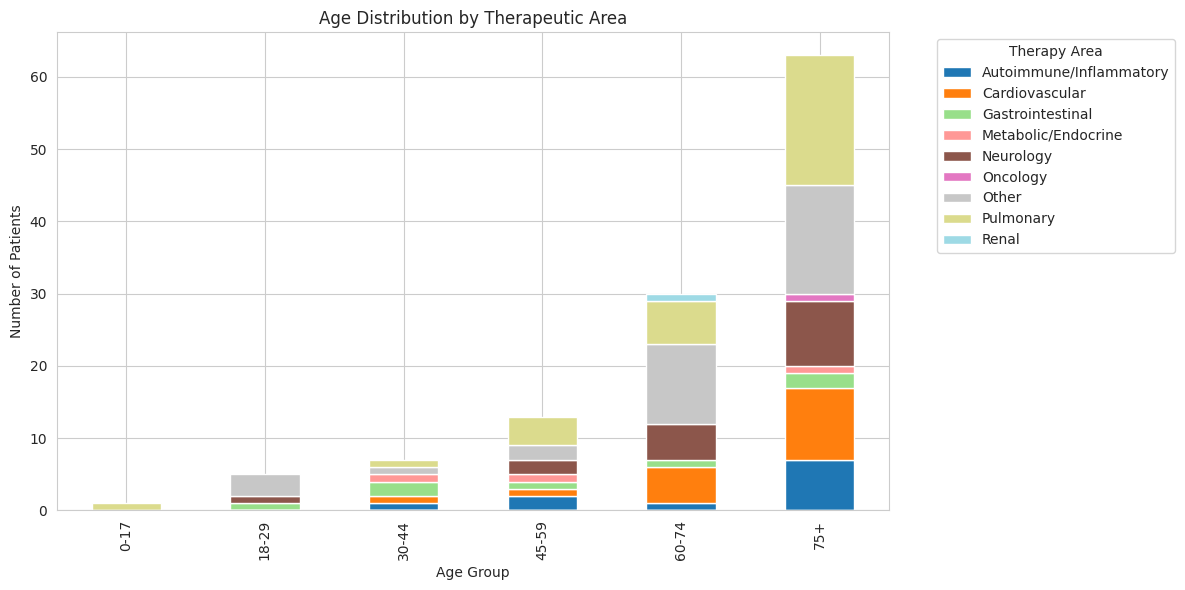

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data
grouped = df_exploded.groupby(['age_group', 'therapy_areas']).size().reset_index(name='count')

# Define age group order
age_order = ['0-17', '18-29', '30-44', '45-59', '60-74', '75+']
grouped['age_group'] = pd.Categorical(grouped['age_group'], categories=age_order, ordered=True)
grouped = grouped.sort_values(['age_group', 'therapy_areas'])

# Pivot to get therapy_areas as columns for stacked bar
pivot_df = grouped.pivot(index='age_group', columns='therapy_areas', values='count').fillna(0)

# Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Age Distribution by Therapeutic Area')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.legend(title='Therapy Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Creating histogram plot...


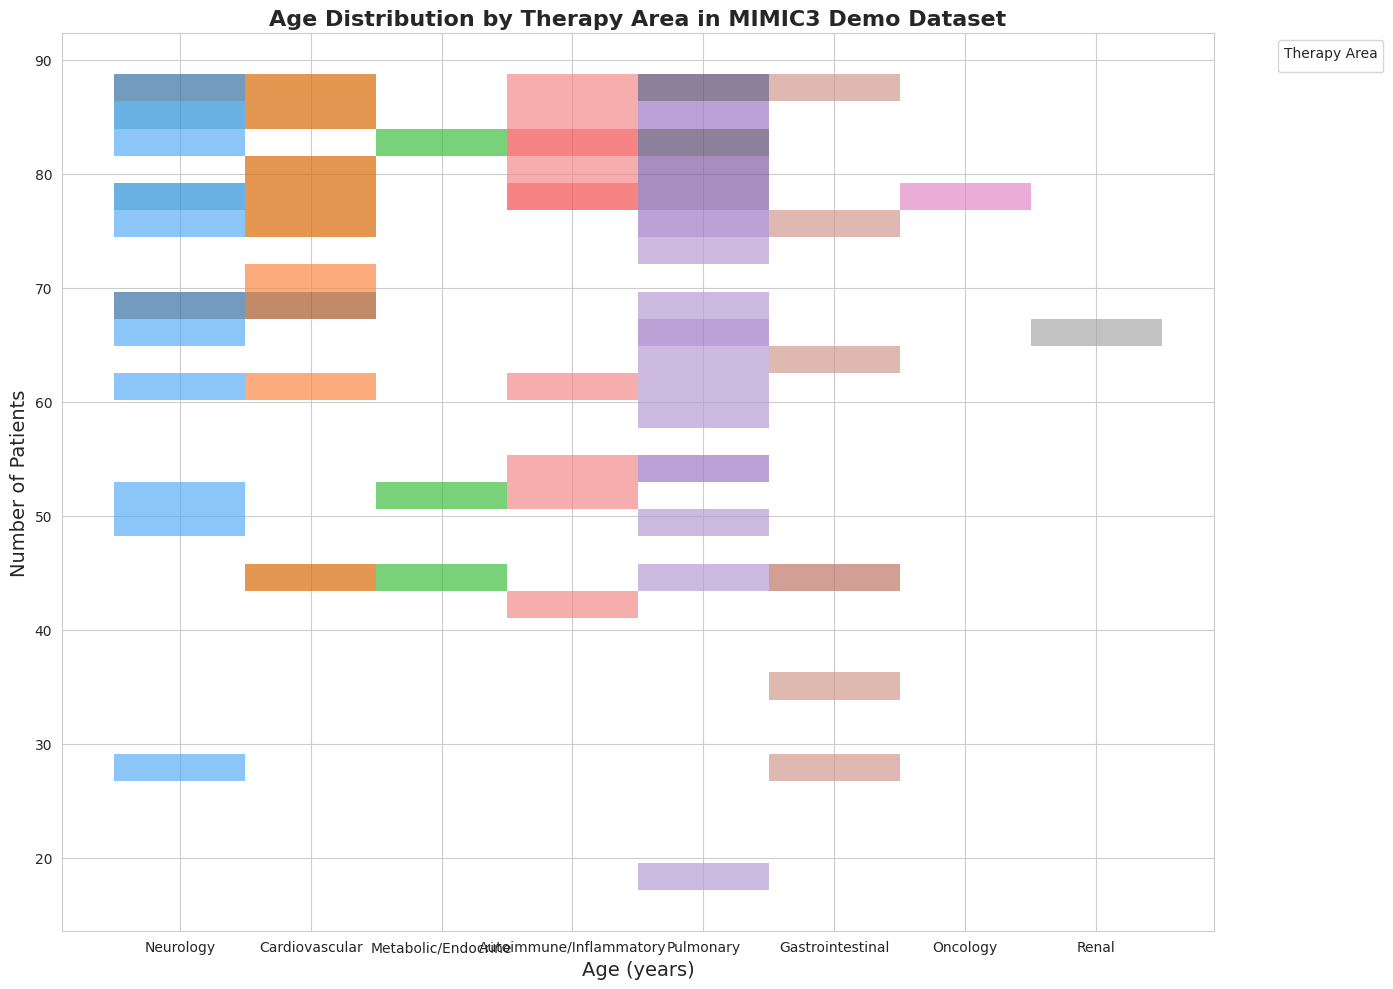

In [30]:
# Plot histogram of age distribution by therapy area
print("Creating histogram plot...")

# Filter out 'Other' category for cleaner visualization
df_exploded = df_exploded.query("age < 200")
plot_df = df_exploded[df_exploded['therapy_areas'] != 'Other']

# Create the plot
plt.figure(figsize=(14, 10))

# Create histogram with hue for therapy areas
g = sns.histplot(
    data=plot_df,
    x='therapy_areas',
    y="age",
    hue='therapy_areas',
    multiple='stack',
    bins=30,
    alpha=0.7
)

plt.title('Age Distribution by Therapy Area in MIMIC3 Demo Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.legend(title='Therapy Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
# Print counts for each therapy area and age group
print("Counts for each therapy area and age group:")
print("=" * 60)

# Create cross-tabulation
cross_tab = pd.crosstab(
    df_exploded['therapy_areas'],
    df_exploded['age_group'],
    margins=True,
    margins_name='Total'
)

print(cross_tab)

print("\n" + "=" * 60)
print("Summary:")
print(f"Total patients: {len(df)}")
print(f"Total patient-therapy area combinations: {len(df_exploded)}")
print(f"Average therapy areas per patient: {len(df_exploded) / len(df):.2f}")
print(f"Age range: {df_exploded['age'].min():.1f} - {df_exploded['age'].max():.1f} years")
print(f"Median age: {df_exploded['age'].median():.1f} years")

Counts for each therapy area and age group:
age_group                0-17  18-29  30-44  45-59  60-74  75+  Total
therapy_areas                                                        
Autoimmune/Inflammatory     0      0      1      2      1    7     11
Cardiovascular              0      0      1      1      5   10     17
Gastrointestinal            0      1      2      1      1    2      7
Metabolic/Endocrine         0      0      1      1      0    1      3
Neurology                   0      1      0      2      5    9     17
Oncology                    0      0      0      0      0    1      1
Other                       0      3      1      2     11   15     32
Pulmonary                   1      0      1      4      6   18     30
Renal                       0      0      0      0      1    0      1
Total                       1      5      7     13     30   63    119

Summary:
Total patients: 100
Total patient-therapy area combinations: 119
Average therapy areas per patient: 1.19
A